<a href="https://colab.research.google.com/github/solayman-cs/COVID/blob/main/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('BTC-USD.csv')

print(df.head())
print(df.describe())
print(df.isnull().sum())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
               Open          High           Low         Close     Adj Close  \
count   2713.000000   2713.000000   2713.000000   2713.000000   2713.000000   
mean   11311.041069  11614.292482  10975.555057  11323.914637  11323.914637   
std    16106.428891  16537.390649  15608.572560  16110.365010  16110.365010   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      606.396973    609.260986    604.109985    606.718

In [ ]:
print(df.columns)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.isnull().sum())
print(df.head())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


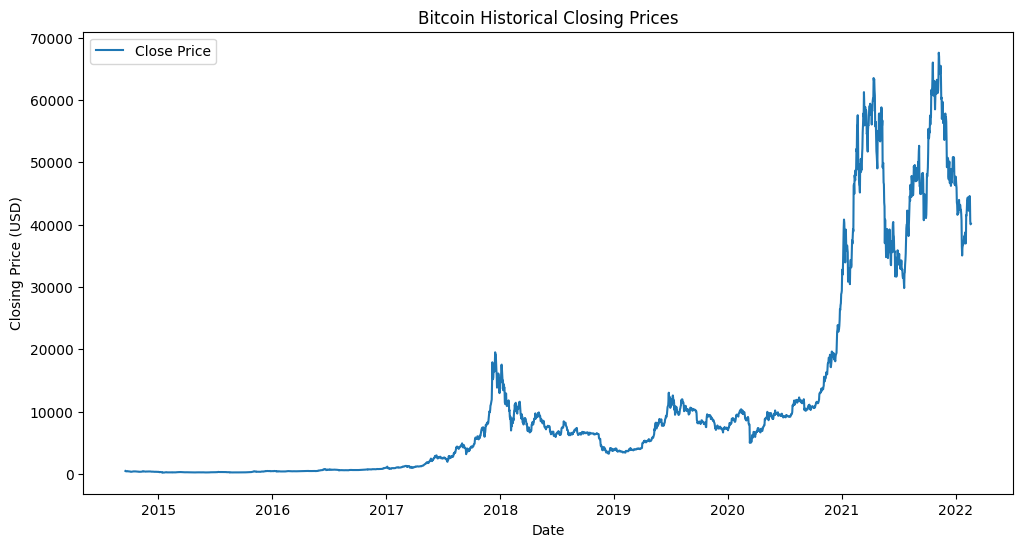

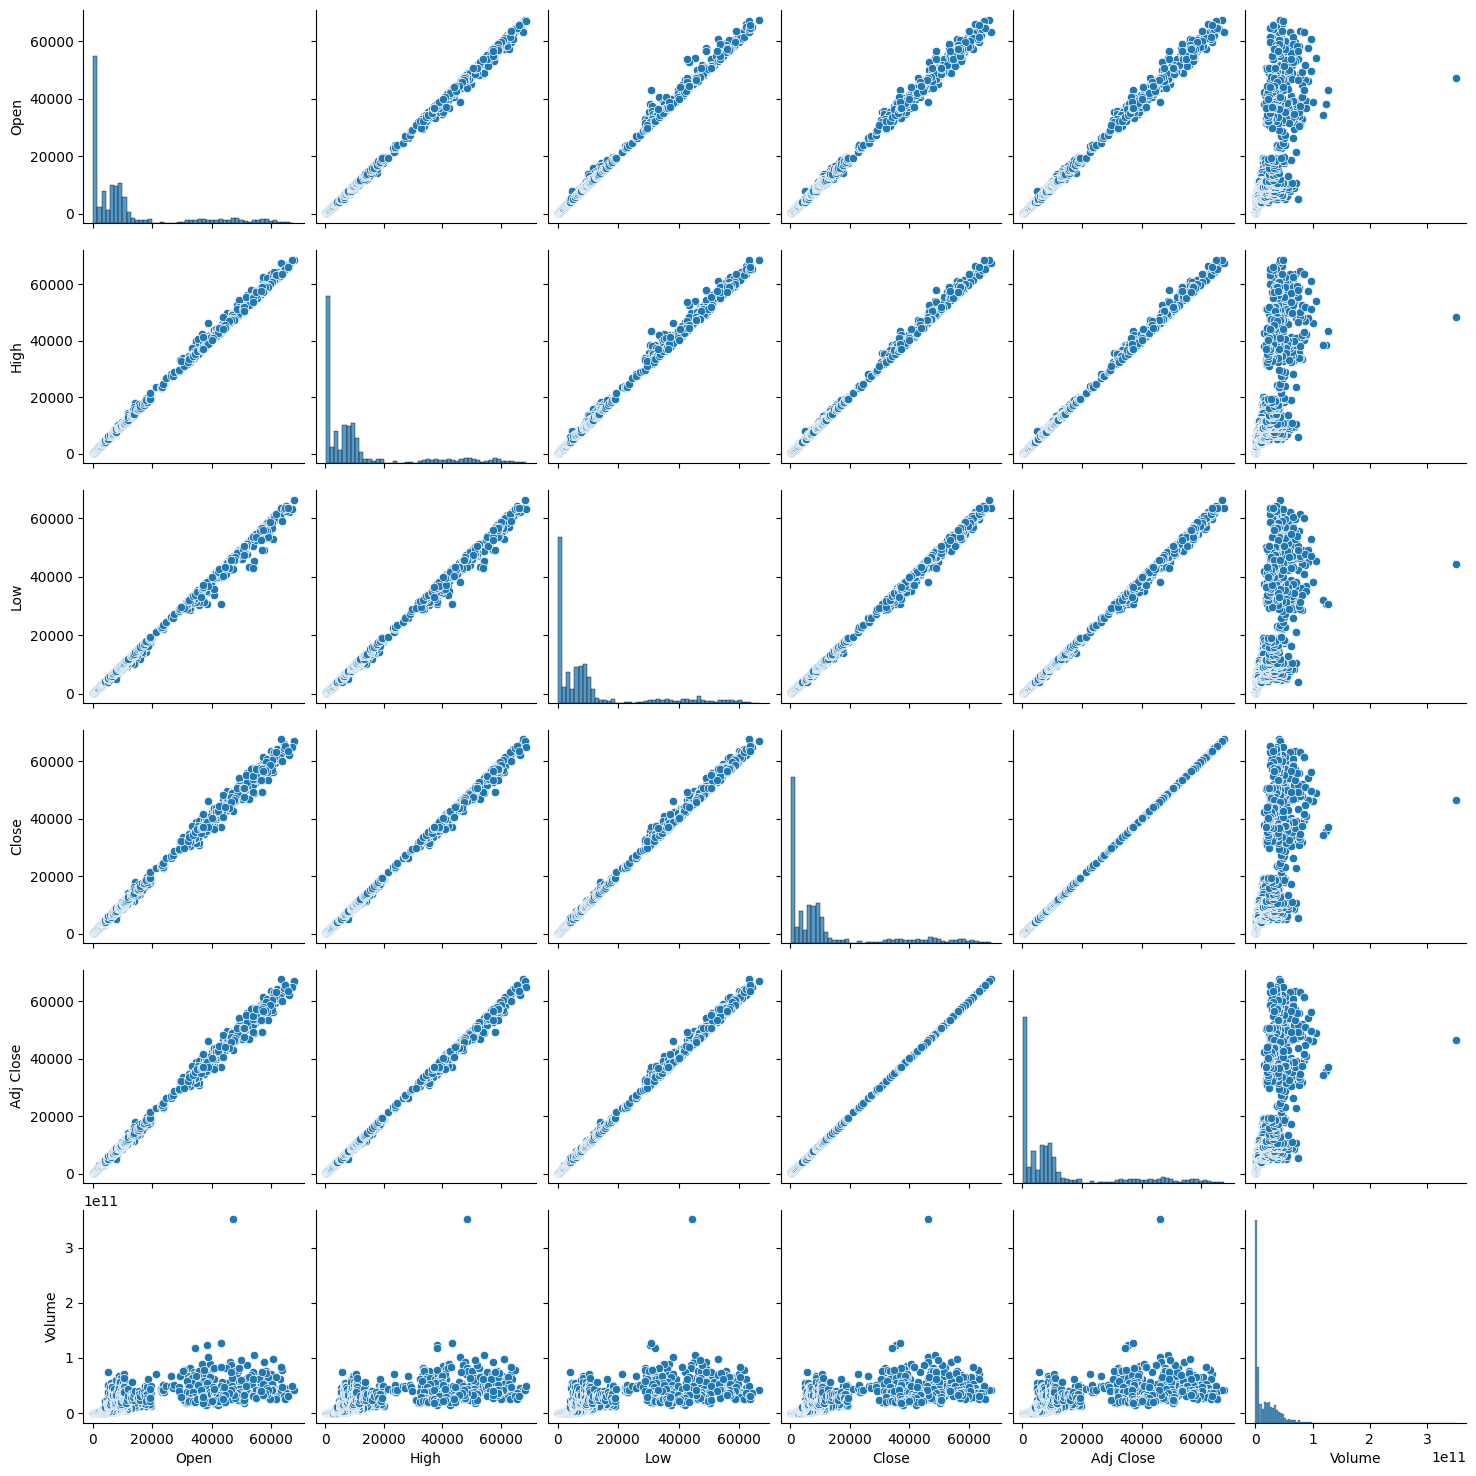

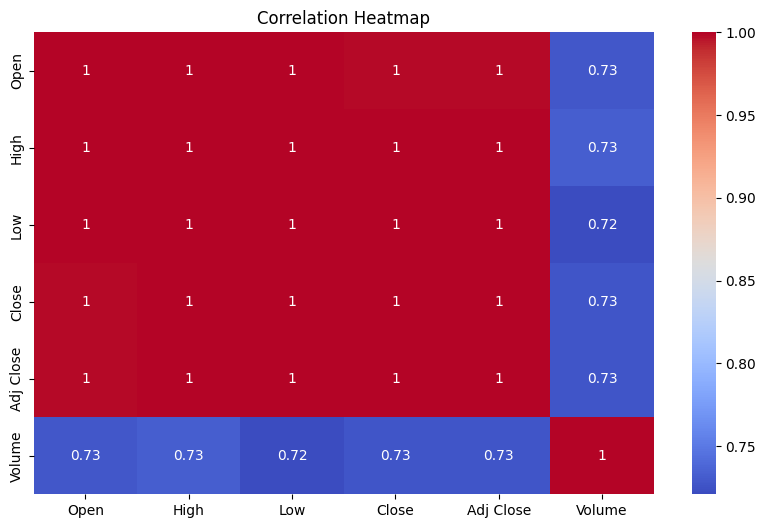

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Bitcoin Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

sns.pairplot(df)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

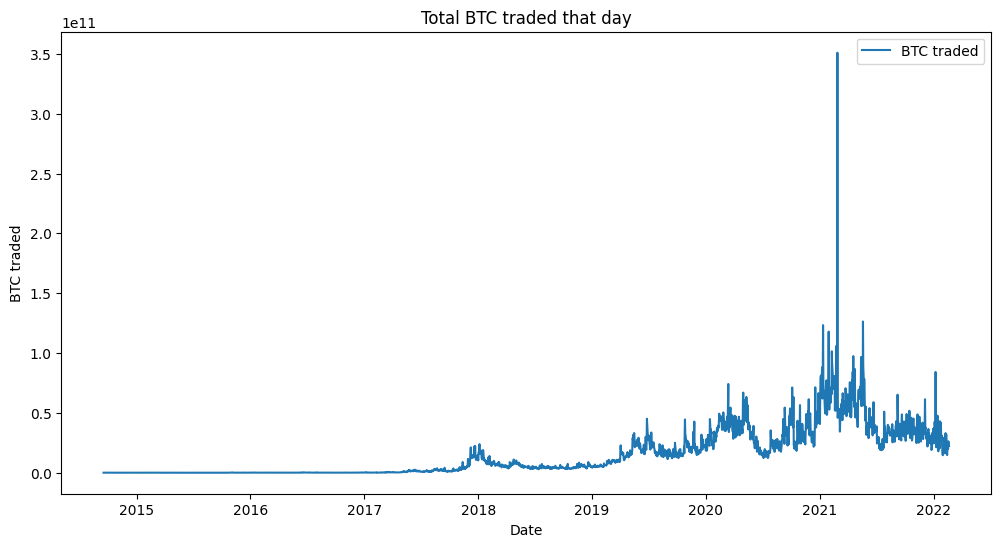

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], label='BTC traded')
plt.title('Total BTC traded that day')
plt.xlabel('Date')
plt.ylabel('BTC traded')
plt.legend()
plt.show()

## Feature Engineering

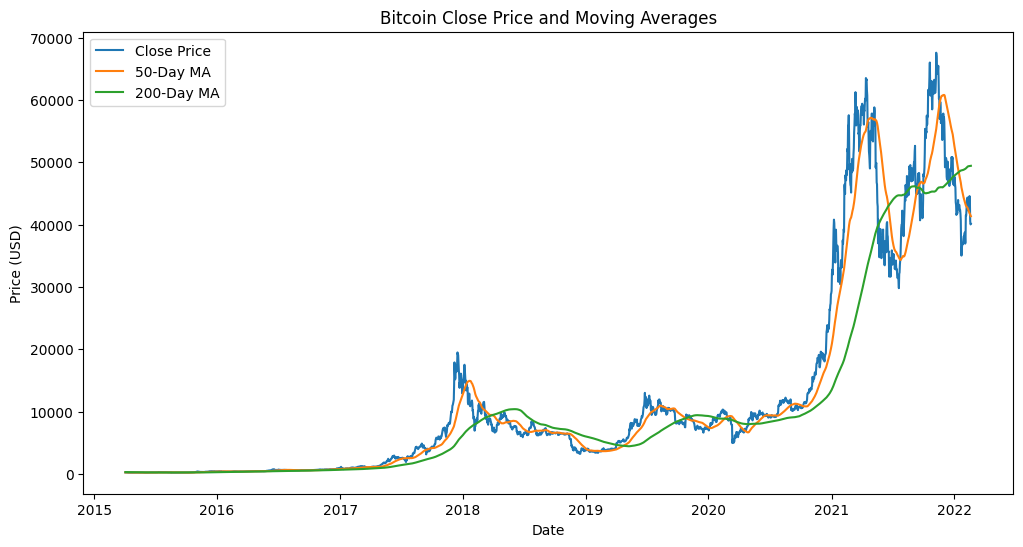

In [ ]:
df['Daily Return'] = df['Close'].pct_change()

# moving average
df['50-Day MA'] = df['Close'].rolling(window=50).mean()
df['200-Day MA'] = df['Close'].rolling(window=200).mean()

df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['50-Day MA'], label='50-Day MA')
plt.plot(df['200-Day MA'], label='200-Day MA')
plt.title('Bitcoin Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


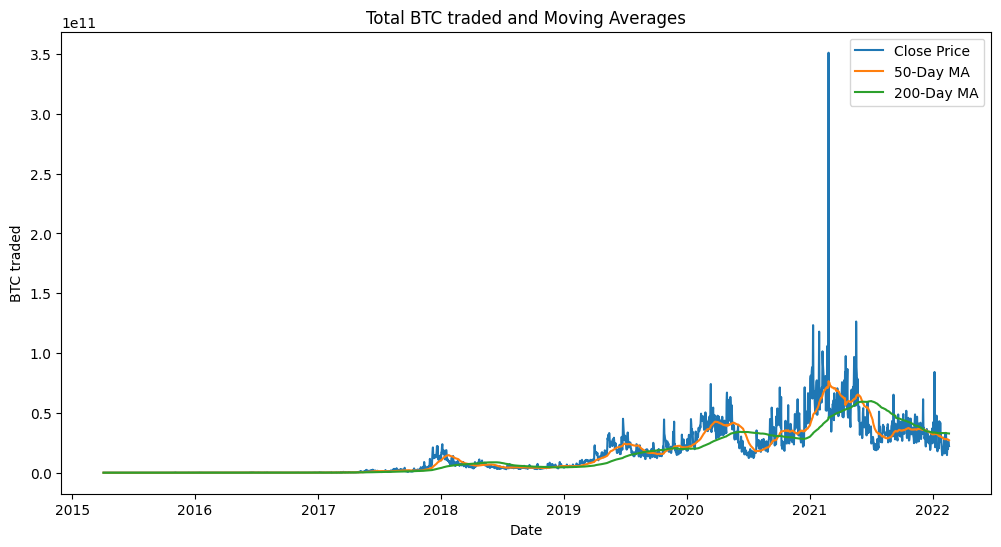

In [ ]:
df['Daily Return'] = df['Volume'].pct_change()

# moving average
df['50-Day MA'] = df['Volume'].rolling(window=50).mean()
df['200-Day MA'] = df['Volume'].rolling(window=200).mean()

df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], label='Close Price')
plt.plot(df['50-Day MA'], label='50-Day MA')
plt.plot(df['200-Day MA'], label='200-Day MA')
plt.title('Total BTC traded and Moving Averages')
plt.xlabel('Date')
plt.ylabel('BTC traded')
plt.legend()
plt.show()

## LSTM Model

Test RMSE: 8,124.17
Test MAE : 6,720.76
Test MAPE: 14.64%


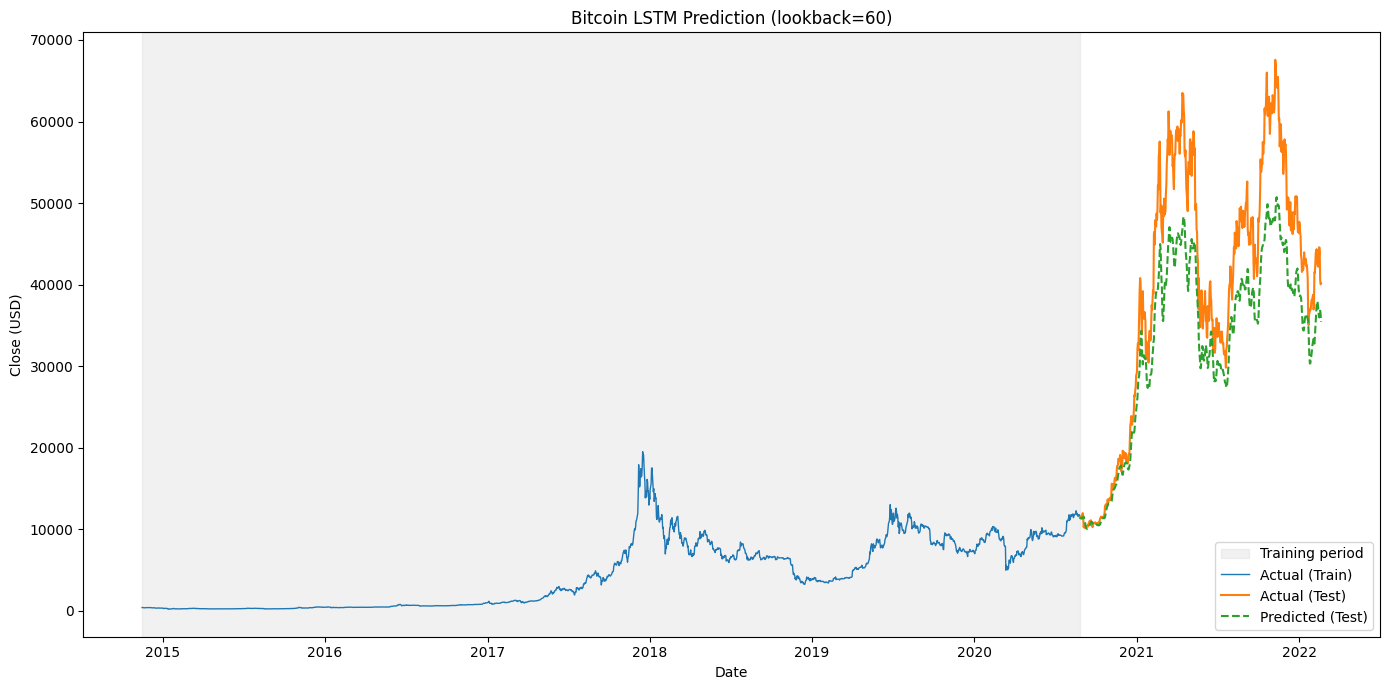

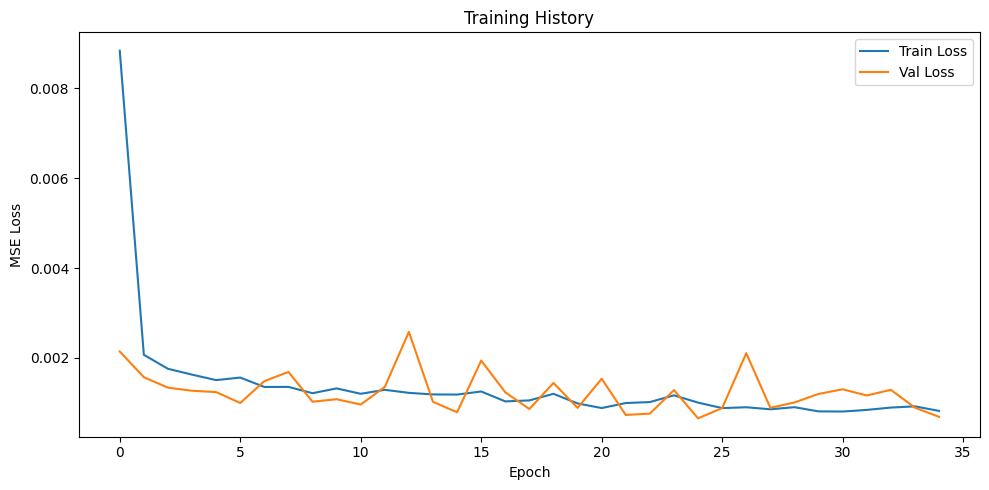

In [ ]:
# === Bitcoin LSTM Prediction: single-cell script =========================================
# Requirements: pandas, numpy, scikit-learn, tensorflow, matplotlib
# -----------------------------------------------------------------------------------------
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Sequential

# --------------------------- Config -------------------------------------------------------
DATA_PATH = "BTC-USD.csv"   # <-- set your CSV path
DATE_COL  = "Date"
TARGET    = "Close"
TEST_SIZE = 0.2             # last 20% of data as test
LOOKBACK  = 60              # sequence length (days)
BATCH     = 64
EPOCHS    = 100
USE_MULTIVARIATE_IF_AVAILABLE = True  # uses OHLCV if present; else Close-only

# --------------------------- Load & Prepare ----------------------------------------------
df = pd.read_csv(DATA_PATH)
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).dropna(subset=[DATE_COL]).reset_index(drop=True)
    df = df.set_index(DATE_COL)

# Pick features
base_cols = [c for c in ["Open","High","Low","Close","Volume"] if c in df.columns]
if USE_MULTIVARIATE_IF_AVAILABLE and set(["Open","High","Low","Close","Volume"]).issubset(df.columns):
    FEATURES = ["Open","High","Low","Close","Volume"]
elif TARGET in df.columns:
    FEATURES = [TARGET]
else:
    raise ValueError("Dataset must contain at least a 'Close' column.")

# Drop rows with missing feature/target
df = df.dropna(subset=FEATURES)

# Split index for train/test (by time, no shuffle)
n = len(df)
n_train = int(n * (1 - TEST_SIZE))
train_df = df.iloc[:n_train]
test_df  = df.iloc[n_train:]

# Scale features with train-only fit
scalers = {}
X_train_raw = train_df[FEATURES].values.astype(np.float32)
X_test_raw  = test_df[FEATURES].values.astype(np.float32)

# Feature scaler (fit on train, apply to both)
x_scaler = MinMaxScaler()
X_train_sc = x_scaler.fit_transform(X_train_raw)
X_test_sc  = x_scaler.transform(X_test_raw)

# Target scaler (fit on train Close only)
y_scaler = MinMaxScaler()
y_train_raw = train_df[[TARGET]].values.astype(np.float32)
y_test_raw  = test_df[[TARGET]].values.astype(np.float32)
y_train_sc  = y_scaler.fit_transform(y_train_raw)
y_test_sc   = y_scaler.transform(y_test_raw)

# Concatenate scaled train+test to create sequences without information leakage
X_full_sc = np.vstack([X_train_sc, X_test_sc])
y_full_sc = np.vstack([y_train_sc, y_test_sc])

# --------------------------- Make sequences ----------------------------------------------
def make_sequences(X_sc, y_sc, lookback, train_cut_idx):
    """
    Build sequences from full series, then split into train/test
    based on the prediction index i (the target at time i).
    """
    X_seq_train, y_seq_train, idx_train = [], [], []
    X_seq_test,  y_seq_test,  idx_test  = [], [], []

    for i in range(lookback, len(X_sc)):
        X_window = X_sc[i-lookback:i]
        y_target = y_sc[i]  # predict the next point (t = i)

        # assign by where target belongs:
        if i <= train_cut_idx - 1:
            X_seq_train.append(X_window)
            y_seq_train.append(y_target)
            idx_train.append(i)
        else:
            X_seq_test.append(X_window)
            y_seq_test.append(y_target)
            idx_test.append(i)

    X_seq_train = np.array(X_seq_train, dtype=np.float32)
    y_seq_train = np.array(y_seq_train, dtype=np.float32)
    X_seq_test  = np.array(X_seq_test,  dtype=np.float32)
    y_seq_test  = np.array(y_seq_test,  dtype=np.float32)
    return X_seq_train, y_seq_train, idx_train, X_seq_test, y_seq_test, idx_test

X_tr, y_tr, idx_tr, X_te, y_te, idx_te = make_sequences(
    X_full_sc, y_full_sc, LOOKBACK, n_train
)

# If feature dimension is 1, ensure shape (samples, lookback, 1)
# Already okay as we built from scaled features, but double-check:
assert X_tr.ndim == 3 and X_te.ndim == 3, "Sequence tensors must be 3D"

# --------------------------- Build LSTM ---------------------------------------------------
tf.keras.utils.set_random_seed(42)
model = Sequential([
    layers.Input(shape=(LOOKBACK, X_tr.shape[-1])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")
es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

hist = model.fit(
    X_tr, y_tr,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es],
    verbose=0
)

# --------------------------- Predict & invert scale ---------------------------------------
y_pred_te_sc = model.predict(X_te, verbose=0)
y_pred_te = y_scaler.inverse_transform(y_pred_te_sc)
y_true_te = y_scaler.inverse_transform(y_te)

# For plotting train region (actuals only; no train preds shown to avoid clutter)
# Map sequence indices back to timestamps
index_arr = df.index.to_numpy()
train_time = index_arr[np.array(idx_tr)]
test_time  = index_arr[np.array(idx_te)]

# --------------------------- Metrics ------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y_true_te, y_pred_te))
mae  = mean_absolute_error(y_true_te, y_pred_te)
mape = np.mean(np.abs((y_true_te - y_pred_te) / np.maximum(np.abs(y_true_te), 1e-8))) * 100

print(f"Test RMSE: {rmse:,.2f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test MAPE: {mape:,.2f}%")

# --------------------------- Plot ---------------------------------------------------------
plt.figure(figsize=(14,7))

# Shade training period
plt.axvspan(train_time[0], train_time[-1], color='lightgrey', alpha=0.3, label='Training period')

# Actual train segment (last part aligns with start of sequences)
plt.plot(train_time, y_scaler.inverse_transform(y_tr), label="Actual (Train)", linewidth=1)

# Actual test
plt.plot(test_time, y_true_te, label="Actual (Test)", linewidth=1.5)

# Predicted test
plt.plot(test_time, y_pred_te, linestyle="--", label="Predicted (Test)", linewidth=1.5)

plt.title(f"Bitcoin LSTM Prediction (lookback={LOOKBACK})")
plt.xlabel("Date"); plt.ylabel(f"{TARGET} (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot training curves
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()
# =========================================================================================
